# Priors and posterior with 1D convolutional networks. 
### Reproduce the Figure 3 in the main paper

### Import libs

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from models import *
from models.skip1D import skip1D
import _pickle as cPickle
dtype = torch.cuda.FloatTensor
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

### Analytical Kernel

In [2]:
def conv_relu_kernel(K):
    theta = np.arccos(K / K[0])
    J = np.sin(theta) + (np.pi - theta) * np.cos(theta)
    K_out = 1 / (2 * np.pi) * K[0] * J
    return K_out


def analytic_kernel(in_sigma, length = 128, num_layers = 4):
    d = np.arange(128)
    if in_sigma > 0:
        K = np.exp(- d * d / (in_sigma * in_sigma * 4))
    else:
        K = np.zeros(length)
        K[0] = 1
    for i in range(num_layers):
        K = conv_relu_kernel(K)
    return K / K[0]

### Effect of input covariance and network depth (Conv-relu network)

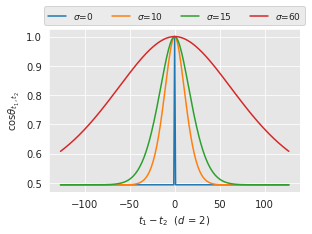

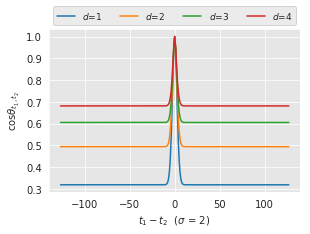

In [3]:
def analytic_kernel_sigma():
    depth = 2
    plt.figure(1, figsize=(4.5,3))
    for in_sigma in [0, 10, 15, 60]:
        cos = analytic_kernel(in_sigma, num_layers = depth)
        whole_array = np.concatenate((np.flip(cos), cos[1:]))
        plt.plot(range(-len(cos)+1, len(cos)), whole_array, label = r'$\sigma$=%d'% in_sigma)
    plt.xlabel(r'$t_1 - t_2$' + r'  ($d$ = 2)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol = 4, prop={'size':9})
    plt.show()

def analytic_kernel_depth():
    in_sigma = 2
    plt.figure(2, figsize=(4.5, 3))
    for depth in [1, 2, 3, 4]:
        # plt.figure(1)
        cos = analytic_kernel(in_sigma, num_layers = depth)
        whole_array = np.concatenate((np.flip(cos), cos[1:]))
        plt.plot(range(-len(cos)+1, len(cos)), whole_array, label = r'$d$=%d'% depth)
    plt.xlabel(r'$t_1 - t_2$'+ r'  ($\sigma$ = 2)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol = 4, prop={'size':9})
    plt.show()   

analytic_kernel_sigma()
analytic_kernel_depth()

### Model

#### (1) Conv-ReLU network

In [4]:
def smooth_input(input, sigma, input_depth = 128):
    kernel_radius = int(np.ceil(3*sigma));
    kernel_size = 2*kernel_radius + 1;
    layer = nn.Conv1d(input_depth, input_depth, kernel_size, padding=kernel_radius, groups=input_depth, bias=False)
    xx = np.arange(-kernel_radius, kernel_radius+1)
    g_weights = np.exp(-xx**2/2/sigma/sigma)
    g_weights  = g_weights/g_weights.sum()
    g_weights  = np.repeat(np.reshape(g_weights, [1, 1, kernel_size]), input_depth, axis=0)
    layer.weight.data = torch.from_numpy(g_weights).float();
    layer.weight.requires_grad = False;
    output = layer(input);
    return output

def simple_model(nsize, input_sigma, net_width, net_depth, input_depth = 128):
    # IID input
    input = Variable(torch.randn(1, input_depth, nsize)).float();
    # add spatial correlation in the input
    if 5*input_sigma > 1:
        input = smooth_input(input, input_sigma)
    input = input.type(dtype)
    # simple CNN model
    model = nn.Sequential()
    model.add(nn.Conv1d(input_depth, net_width, 3, bias=False))
    model.add(nn.ReLU())
    for i in range(net_depth-1):
        model.add(nn.Conv1d(net_width, net_width, 3, bias=False))
        model.add(nn.ReLU())
    model.add(nn.Conv1d(net_width, 1, 3, bias=False))
    model.type(dtype)
    # normal initialization
    for n in [x for x in model.parameters() if len(x.size()) == 3]:
        nn.init.normal_(n, mean = 0, std = 1. / np.sqrt(n.size()[1]* 3))
    return model,input

output_size = 128
net_depth = 2
nsize = output_size + 2 * (net_depth + 1)
model,input = simple_model(nsize, 10, 128, net_depth)
print(model)

Sequential(
  (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
  (2): ReLU()
  (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
  (4): ReLU()
  (5): Conv1d(128, 1, kernel_size=(3,), stride=(1,), bias=False)
)


#### (2) Auto-encoder

In [5]:
def auto_encoder(nsize, input_sigma, net_width, net_depth=3, input_depth = 128):
    
    input = Variable(torch.randn(1, input_depth, nsize)).float();
    if 5*input_sigma > 1:
        input = smooth_input(input, input_sigma, input_depth)
    input = input.type(dtype)
    model = skip1D(
        input_depth, 1,
        num_channels_down = [net_width]*net_depth,
        num_channels_up   = [net_width]*net_depth,
        num_channels_skip = [0]*net_depth,
        upsample_mode='linear',
        downsample_mode='avg',
        filter_size_down=3, 
        filter_size_up=3,
        need_sigmoid=False,
        need_bias=False, 
        pad='reflection', 
        act_fun=nn.ReLU).type(dtype)

    for n in [x for x in model.parameters() if len(x.size()) == 3]:
        nn.init.kaiming_normal(n)

    return model, input

output_size = 128
net_depth = 2
nsize = output_size + 2 * (net_depth + 1)
model,input = auto_encoder(nsize, 10, 128, net_depth)
print(model)

Sequential(
  (1): Sequential(
    (1): Sequential(
      (0): ReflectionPad1d((1, 1))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
      (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): Identity()
    (3): ReLU()
    (4): Sequential(
      (0): ReflectionPad1d((1, 1))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
    )
    (5): Identity()
    (6): ReLU()
    (7): Sequential(
      (1): Sequential(
        (1): Sequential(
          (0): ReflectionPad1d((1, 1))
          (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
          (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        )
        (2): Identity()
        (3): ReLU()
        (4): Sequential(
          (0): ReflectionPad1d((1, 1))
          (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), bias=False)
        )
        (5): Identity()
        (6): ReLU()
        (7): Upsample(scale_factor=2, mode=linear)
      )
      

### Prior

In [10]:
def compute_mean_cov_from_samples(samples, margin = 1000, length = 128):

    samples = np.squeeze(samples)
    kernel = samples.T.dot(samples) / samples.shape[0] 
    # compute the stationary version K_d
    K_d = np.zeros(length)
    for d in range(length):
        count = 0.
        for row in range(margin, margin+length):
            if row + d < kernel.shape[0]:
                K_d[d] += kernel[row, row+d]
                count += 1
        K_d[d] /= count
    mean = np.mean(samples[:, margin:margin+length], axis = 0)
    return mean, K_d

# compute k_d numerically with different sigma
def prior_sampling(in_sigma, net_width, net_depth, num_samples = 2000, 
                    out_size = 128, cnn = 'simple'):
    inputs = []
    samples = []
    print('Sampling from CNN...')
    for i in range(num_samples):
        if cnn == 'simple':
            nsize = out_size + 2 * (net_depth + 1)
            [model, input] = simple_model(nsize, in_sigma, net_width, net_depth)
        elif cnn == 'auto_encoder':
            nsize = out_size
            [model, input] = auto_encoder(nsize, in_sigma, net_width, net_depth)
        output = model(input).cpu().data.numpy().reshape((out_size, 1))
        samples.append(output)
    samples = np.array(samples)
    return samples

# visualize samples from prior
def draw_prior(in_sigma, net_depth):
    # plot priors of NN
    xx = np.arange(0, samples[0].shape[0]);
    plt.figure(2, figsize = (4, 3))
    plt.clf()
    for i in range(5):
        plt.plot(xx, samples[i])
    plt.title(r'$\sigma$ = %d, $d$ = %d'% (in_sigma, net_depth))
    plt.xlabel('input, x')
    plt.ylabel('output, f(x)')
    plt.ylim(-0.6, 0.6)
    plt.show()

#### (1) Visualize samples from prior

Sampling from CNN...


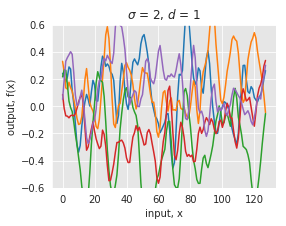

Sampling from CNN...


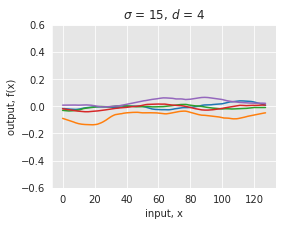

In [130]:
net_width = 128
in_sigma = 2
net_depth = 1
samples = prior_sampling(in_sigma, net_width, net_depth, num_samples = 5)
draw_prior(in_sigma, net_depth)
mean, K_d = compute_mean_cov_from_samples(samples, margin = 1000)

in_sigma = 15
net_depth = 4
samples = prior_sampling(in_sigma, net_width, net_depth, num_samples = 5)
draw_prior(in_sigma, n32et_depth)
mean, K_d = compute_mean_cov_from_samples(samples, margin = 0)

#### (2) Compute output covariance empirically

Sampling from CNN...


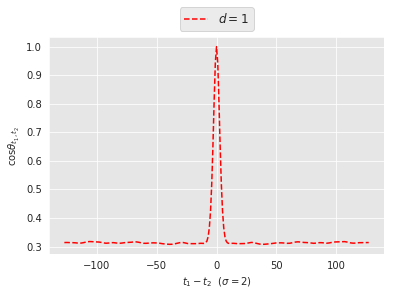

In [131]:
in_sigma = 2
net_depth = 1
samples = prior_sampling(in_sigma, net_width, net_depth, num_samples = 5000, out_size = 2048)
mean, K_d = compute_mean_cov_from_samples(samples, margin = 1000)

NN_cos_ang = K_d/K_d[0]
x = np.arange(-len(mean)+1, len(mean))
nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))

plt.plot(x, nn_cos_all, 'r', linestyle = '--', label = r'$d=%d$'% net_depth)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':12})
plt.xlabel(r'$t_1 - t_2$' + r'  ($\sigma=2$)')
plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
plt.pause(1)

#### (3) compare the analytical and numerical kernel

In [16]:
net_width = 256

def compare_kernel_depth():
    layers_list = [1, 2, 3, 4]
    in_sigma = 2
    color = ['r', 'b', 'g', 'y']
    for idx, num_layers in enumerate(layers_list):
        
        cos_ang = analytic_kernel(in_sigma, num_layers = num_layers)
        samples = prior_sampling(in_sigma, net_width, num_layers, num_samples = 10000, out_size = 4096)
        mean, kd = compute_mean_cov_from_samples(samples, margin = 1000)
        print(mean.shape)
        NN_cos_ang = kd/kd[0]
        x = np.arange(-len(mean)+1, len(mean))
        gp_cos_all = np.concatenate((np.flip(cos_ang), cos_ang[1:]))
        nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))
        plt.plot(x, gp_cos_all, color[idx], label = r'$d=%d$'% num_layers)
        plt.plot(x, nn_cos_all, color[idx], linestyle = '--')
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':9})
    plt.xlabel(r'$t_1 - t_2$' + r'  ($\sigma=2$)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.show()
 

def compare_kernel_sigma():
    input_sigma_list = [0, 10, 15, 60]
    num_layers = 4
    color = ['r', 'b', 'g', 'y']
    for idx, in_sigma in enumerate(input_sigma_list):
        cos_ang = analytic_kernel(in_sigma, num_layers = num_layers)
        samples = prior_sampling(in_sigma, net_width, num_layers, num_samples = 50000, out_size = 2048)
        # "margin = 1000" is to avoid the estimation bias caused by the padding operation in Gaussian filtering
        mean, kd = compute_mean_cov_from_samples(samples, margin = 1000)        
        NN_cos_ang = kd/kd[0]
        x = np.arange(-len(mean)+1, len(mean))
        gp_cos_all = np.concatenate((np.flip(cos_ang), cos_ang[1:]))
        nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))
        plt.plot(x, gp_cos_all, color[idx], label = r'$\sigma=%d$'% in_sigma)
        plt.plot(x, nn_cos_all, color[idx], linestyle = '--')
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':9})
    plt.xlabel(r'$t_1 - t_2$' + r'  ($d=4$)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.show()
 

Sampling from CNN...
(128,)
Sampling from CNN...
(128,)
Sampling from CNN...
(128,)
Sampling from CNN...
(128,)


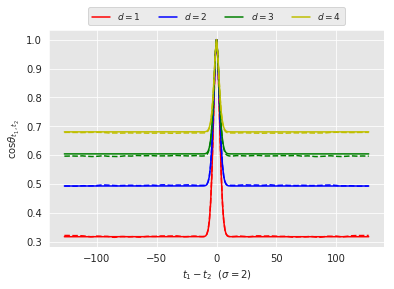

In [160]:
compare_kernel_depth()

Sampling from CNN...
Sampling from CNN...
Sampling from CNN...
Sampling from CNN...


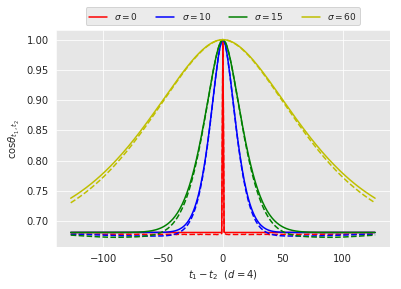

In [17]:
compare_kernel_sigma()

#### Auto-encoder: empirical kernel

In [21]:
def auto_encoder_kernel_sigma():
    input_sigma_list = [0, 20, 60, 120]
    num_layers = 3
    color = ['r', 'b', 'g', 'y']
    for idx, in_sigma in enumerate(input_sigma_list):
        samples = prior_sampling(in_sigma, net_width, num_layers, num_samples = 50000, out_size = 2048, cnn = 'auto_encoder')
        mean, kd = compute_mean_cov_from_samples(samples, margin = 1000)        
        NN_cos_ang = kd/kd[0]
        x = np.arange(-len(mean)+1, len(mean))
        nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))
        plt.plot(x, nn_cos_all, color[idx], label = r'$\sigma=%d$'% in_sigma)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':9})
    plt.xlabel(r'$t_1 - t_2$' + r'  ($d=3$)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.show()

Sampling from CNN...
Sampling from CNN...
Sampling from CNN...
Sampling from CNN...


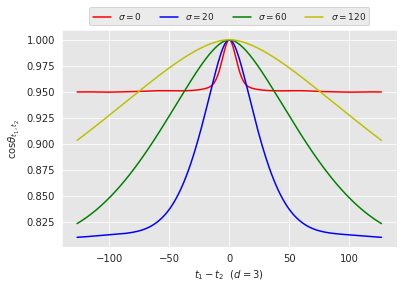

In [14]:
net_width = 32 # increase this parameter to approximate Gaussian Process behavior better.
auto_encoder_kernel_sigma()

In [22]:
def auto_encoder_kernel_depth():
    num_layers_list = [3, 4, 5, 6]
    in_sigma = 0
    color = ['r', 'b', 'g', 'y']
    for idx, num_layers in enumerate(num_layers_list):
        samples = prior_sampling(in_sigma, net_width, num_layers, num_samples = 50000, out_size = 4096, cnn = 'auto_encoder')
        mean, kd = compute_mean_cov_from_samples(samples, margin = 2000)        
        NN_cos_ang = kd/kd[0]
        x = np.arange(-len(mean)+1, len(mean))
        nn_cos_all = np.concatenate((np.flip(NN_cos_ang), NN_cos_ang[1:]))
        plt.plot(x, nn_cos_all, color[idx], label = r'$d=%d$'% num_layers)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.00001), ncol=4, prop={'size':9})
    plt.xlabel(r'$t_1 - t_2$' + r'  ($\sigma=0$)')
    plt.ylabel(r'$\cos \theta_{t_1, t_2}$')
    plt.show()

Sampling from CNN...
Sampling from CNN...
Sampling from CNN...
Sampling from CNN...


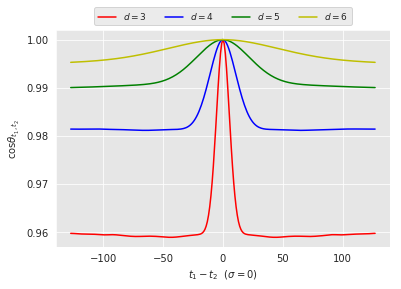

In [23]:
net_width = 256
# increase num_samples or net_width to reduce the estimation error (the tile will be flatter)
# the following figure uses 50000 samples
auto_encoder_kernel_depth()

### Posterior

In [155]:
torch.manual_seed(1000)
np.random.seed(1000)

nsize = 128; # for SGLD posterior
input_depth = 4
learning_rate = 0.001;
param_noise_sigma = 2
noise_scale = 0.0;
mask_threshold = 0.9;
max_iter = 8000; # Sometimes this has to be increased with more smoothing
burnin_iter = 5000;
num_epochs = 1; # Number of restarts

# target function
x = np.linspace(0, 1, nsize);
ytrue = 0.3*np.sin(8*np.pi * x) + 0.1*np.sin(32*np.pi*x)
ynoise =  np.random.randn(nsize)*noise_scale;
y = ytrue + ynoise
m = np.random.rand(nsize) > mask_threshold;

target = Variable(torch.from_numpy(y)).view((1, 1, nsize)).float();
mask = Variable(torch.from_numpy(m.astype('float32'))).view((1,1,nsize));

xx = np.arange(0,nsize);
y = target.data.numpy().reshape((nsize,1));

In [156]:
def add_noise(model):
    for n in [x for x in model.parameters() if len(x.size()) == 3]:
        noise = torch.randn(n.size())*param_noise_sigma*learning_rate
        noise = noise.type(dtype)
        n.data = n.data + noise

## run sgld, compute the mean and variance numerically
def sgld_posterior(in_sigma, net_depth, net_width = 32, out_size = 128): 
     
    target_var = target.type(dtype)
    mask_var = mask.type(dtype)
    nsize = out_size + 2 * (net_depth + 1)
    # Initialize model randomly and inference via SGLD
    [model, input] = simple_model(nsize, in_sigma, net_width, net_depth)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    plt.figure(3) 
    plt.clf()
    samples = []
    for i in range(max_iter):
        if np.mod(i, 500) == 0:
            print('iter %d' % i)
        output = model(input);
        diff = (output - target_var)*mask_var;
        loss = (diff*diff).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        add_noise(model)
        if i > burnin_iter and np.mod(i, 20) == 0:
            y_ = output.cpu().data.numpy().reshape((out_size,1));
            samples.append(y_)
            plt.plot(xx, y_, '-')
            plt.plot(xx, ytrue, 'k-')
            plt.plot(xx[m], y[m], 'r.')
            plt.title('Iter: %d' % i)
            plt.pause(0.05)
    # compute the mean and covariance at each point
    samples = np.squeeze(np.array(samples))
    mean = np.mean(samples, axis = 0)
    std = np.std(samples, axis = 0)
    kernel = np.eye(len(std)) * std**2
    return mean, kernel

# plot errorbar
def plot_errorbar(mean, kernel, title = '', filename = ''):

    plt.figure(6, figsize = (4, 3))
    plt.clf()
    mean = np.squeeze(mean)
    stds = np.array([np.sqrt(kernel[i,i]) for i in range(kernel.shape[0])])
    plt.plot(xx, ytrue, 'k-')
    plt.plot(xx[m], y[m], 'ro')
    line, = plt.plot(xx, mean)
    plt.fill_between(xx, mean - stds, mean + stds,
                     color=line.get_color(), alpha=0.2)
    plt.title(title)
    plt.xlabel('input, x')
    plt.ylabel('output, f(x)')
    plt.ylim(-1, 1)
    plt.show(block=False)

In [ ]:
in_sigma = 2
net_depth = 1
net_width = 32  # increase net_width to approximate the Gaussian Process Behavior better
mean_sgld, cov_sgld = sgld_posterior(in_sigma, net_depth, net_width)
plot_errorbar(mean_sgld, cov_sgld,  r'SGLD Posterior: $\sigma$ = %d, $d$ = %d' % (in_sigma, net_depth))

In [ ]:
in_sigma = 15
net_depth = 4
net_width = 32  # increase net_width to approximate the Gaussian Process Behavior better
mean_sgld, cov_sgld = sgld_posterior(in_sigma, net_depth, net_width)
plot_errorbar(mean_sgld, cov_sgld, r'SGLD Posterior: $\sigma$ = %d, $d$ = %d' % (in_sigma, net_depth))